In [3]:
import scanpy as sc

In [1]:
import scvi

AttributeError: module 'scvi' has no attribute 'data'

In [5]:
import numpy as np

# RNA

In [6]:
adata = scvi.data.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/anndata_rna.h5ad")

Remove genes which are exprssed at very low levels or other outliers. Scvi tools use the raw count matrix. We can save the raw count matrix in an extra layer and then normalize the count matrix for other tasks. 

In [19]:
sc.pp.filter_genes(adata, min_counts=3)

In [20]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`
adata.raw

The counts matrix contains the raw counts:

In [12]:
adata.layers["counts"][0:5, 0:5].todense()

matrix([[4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)

In [13]:
adata.raw[0:5, 0:5]

Reduce the number of features which will be used as input for the model. You can use 1,000 to 10,000 most highly variable genes. Lets try with 10,000 first. Here we can already add a batch_key which means that the highly variable genes will be selected for each "batch" separately. We will not select all highly variable genes from just one "batch". In our case the only batch effect we would expect is between cells of different replicates. 

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample"
)

In [11]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["sample"],
    continuous_covariate_keys=["mitochondrial_percent_RNA", "ribosomal_percent_RNA"]
)

/home/k552k/.cache/R/basilisk/1.4.0/zellkonverter/1.5.0/zellkonverterAnnDataEnv/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Create a model. 

In [12]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    
    dropout_rate=0.2,
    n_layers=2,n_latent=20,gene_likelihood='nb'
)

model = scvi.model.SCVI(
    adata,
    **arches_params
)

In [16]:
#model = scvi.model.SCVI(adata)

In [14]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Not Trained

Train the model.

In [18]:
 #model.train()

Save the model

In [19]:
#model.save("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/scvi_models/")

In [18]:
model =  scvi.model.SCVI.load("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/scvi_models/", adata=adata, use_gpu=False)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

### scVI Output

In [20]:
#latent = model.get_latent_representation()

We can save the output of the model in the anndata object:

In [21]:
#adata.obsm["X_scVI"] = latent

# Visualization without batch correction

In [22]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

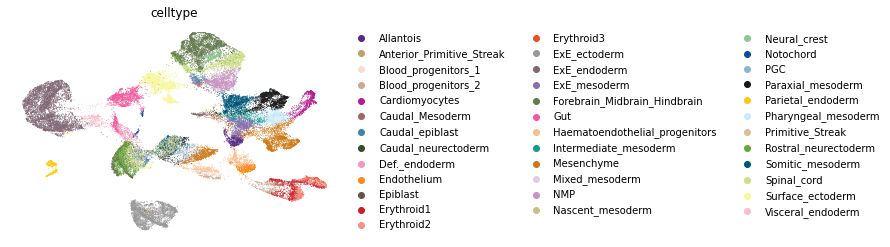

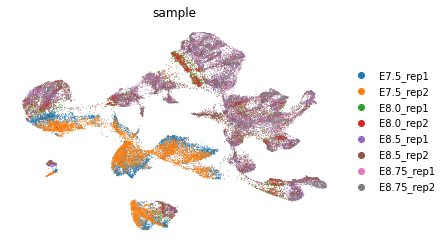

In [23]:
sc.pl.umap(
    adata,
    color=["celltype"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["sample"],
    ncols=2,
    frameon=False,
)

# Visualization after Batch correction

In [24]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

ValueError: Did not find X_scVI in `.obsm.keys()`. You need to compute it first.

In [ ]:
sc.pl.umap(
    adata,
    color=["celltype"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["sample"],
    ncols=2,
    frameon=False,
)